In [94]:
# Initialize PaddleOCR instance
from paddleocr import PaddleOCR
ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False,
    lang='fr')

# Run OCR inference on a sample image 
result = ocr.predict(
    input="test.jpg")  # Change to your image path

# Visualize the results and save the JSON results
for res in result:
    res.print()
    res.save_to_img("output")
    res.save_to_json("output")

MKL-DNN is not available. Using `paddle` instead.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /Users/teo/.paddlex/official_models.
Creating model: ('latin_PP-OCRv5_mobile_rec', None)
Using official model (latin_PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in /Users/teo/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Resized image size (14175x800) exceeds max_side_limit of 4000. Resizing to fit within limit.
{'res': {'input_path': 'test.jpg', 'page_index': None, 'model_settings': {'use_doc_preprocessor': True, 'use_textline_orientation': False}, 'doc_preprocessor_res': {'input_path': None, 'page_index': None, 'model_settings': {'use_doc_orientation_classify': False, 'use_doc_unwarping': False}, 'angle': -1}, 'dt_polys': array([[[  182,  3029],
        ...,
        [  177,  3082]],

       ...,

       [[    3, 13424],
        ...,
        [    5, 13474]]], shape=(19, 4, 2), dtype=int16), 'text_det_params': {'limit_side_len': 64, 'limit_type': 'min', 'thresh': 0.3, 'max_side_limit': 4000, 'box_thresh': 0.6, 'unclip_ratio': 1.5}, 'text_type': 'general', 'textline_orientation_angles': array([-1, ..., -1], shape=(19,)), 'text_rec_score_thresh': 0.0, 'rec_texts': ["J'ÉTAIS", 'POURTANT...', 'EN PLEIN', 'COMBAT AVEC CANE', 'CORSO...', 'MON SEPTIÈME', 'CROC A ÉTÉ DÉTRUIT', 'PAR SON NEUVIÈME,', "ET JE L'AI"

In [95]:
result[0]

{'input_path': 'test.jpg',
 'page_index': None,
 'doc_preprocessor_res': {'input_path': None,
  'page_index': None,
  'input_img': array([[[0, ..., 0],
          ...,
          [0, ..., 0]],
  
         ...,
  
         [[0, ..., 0],
          ...,
          [1, ..., 1]]], shape=(14175, 800, 3), dtype=uint8),
  'model_settings': {'use_doc_orientation_classify': False,
   'use_doc_unwarping': False},
  'angle': -1,
  'rot_img': array([[[0, ..., 0],
          ...,
          [0, ..., 0]],
  
         ...,
  
         [[0, ..., 0],
          ...,
          [1, ..., 1]]], shape=(14175, 800, 3), dtype=uint8),
  'output_img': array([[[0, ..., 0],
          ...,
          [0, ..., 0]],
  
         ...,
  
         [[0, ..., 0],
          ...,
          [1, ..., 1]]], shape=(14175, 800, 3), dtype=uint8)},
 'dt_polys': [array([[ 182, 3029],
         ...,
         [ 177, 3082]], shape=(4, 2), dtype=int16),
  array([[ 143, 3090],
         ...,
         [ 143, 3129]], shape=(4, 2), dtype=int16),
  

In [263]:
from shapely.geometry import Polygon
import networkx as nx

def cluster_polygons(polys_points, margin_factor=0.1):
    """
    Cluster des polygones en fonction de leur chevauchement.
    La marge autour de chaque polygone est proportionnelle à sa taille.
    
    Parameters:
    - polys_points: liste de np.array, chaque array contient les points (x, y) du polygone
    - margin_factor: float, fraction de la "taille" du polygone utilisée comme marge
    
    Returns:
    - clusters: liste de sets, chaque set contient les indices des polygones du cluster
    """
    
    polygons = [Polygon(p) for p in polys_points]
    
    # Agrandir chaque polygone proportionnellement à sa taille
    polygons_expanded = []
    for poly in polygons:
        size = poly.area**0.5  # racine carrée de l'aire comme mesure de taille
        margin = size * margin_factor
        polygons_expanded.append(poly.buffer(margin))
    
    # Construire le graphe
    G = nx.Graph()
    G.add_nodes_from(range(len(polygons_expanded)))
    
    for i in range(len(polygons_expanded)):
        for j in range(i+1, len(polygons_expanded)):
            if polygons_expanded[i].intersects(polygons_expanded[j]):
                G.add_edge(i, j)
    
    clusters = list(nx.connected_components(G))
    return clusters


In [264]:
cluster_polygons(result[0]["rec_polys"], margin_factor=0.1)

[{0, 1},
 {2, 3, 4},
 {5, 6, 7},
 {8, 9, 10},
 {11, 12},
 {13},
 {14, 15},
 {16, 17},
 {18}]

In [265]:
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon

def draw_clusters_polygons(polys_points, margin_factor=0.1, dpi=600, linewidth=0.2):
    """
    Dessine des polygones groupés par cluster.
    Chaque polygone est dessiné deux fois : original et agrandi avec une marge proportionnelle à sa taille.
    
    Parameters:
    - polys_points: liste de np.array, chaque array contient les points (x,y) du polygone
    - margin_factor: float, fraction de la "taille" du polygone utilisée comme marge
    - dpi: résolution de l'image
    - linewidth: épaisseur des traits
    """
    # Clustering avec marge proportionnelle
    clusters = cluster_polygons(polys_points, margin_factor=margin_factor)
    
    plt.figure(figsize=(12, 12), dpi=dpi)
    ax = plt.gca()
    
    # Convertir chaque polygone pour matplotlib
    polys = [Polygon(p) for p in polys_points]
    
    # Dessiner chaque cluster avec une couleur différente
    for cluster in clusters:
        color = [random.random() for _ in range(3)]
        for idx in cluster:
            poly = polys[idx]
            # Polygon original
            ax.add_patch(plt.Polygon(list(poly.exterior.coords), fill=False, edgecolor=color, linewidth=linewidth))
            
            # Polygon agrandi avec marge proportionnelle à sa taille
            size = poly.area**0.5  # racine carrée de l’aire
            margin = size * margin_factor
            poly_buffered = poly.buffer(margin)
            ax.add_patch(plt.Polygon(list(poly_buffered.exterior.coords), fill=False, edgecolor=color, linestyle='--', linewidth=linewidth))
    
    # Ajuster limites
    all_x = [pt[0] for p in polys_points for pt in p]
    all_y = [pt[1] for p in polys_points for pt in p]
    ax.set_xlim(min(all_x) - 50, max(all_x) + 50)
    ax.set_ylim(min(all_y) - 50, max(all_y) + 50)
    ax.invert_yaxis()
    
    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Clusters de polygones (plein = original, tireté = agrandi)')
    plt.show()


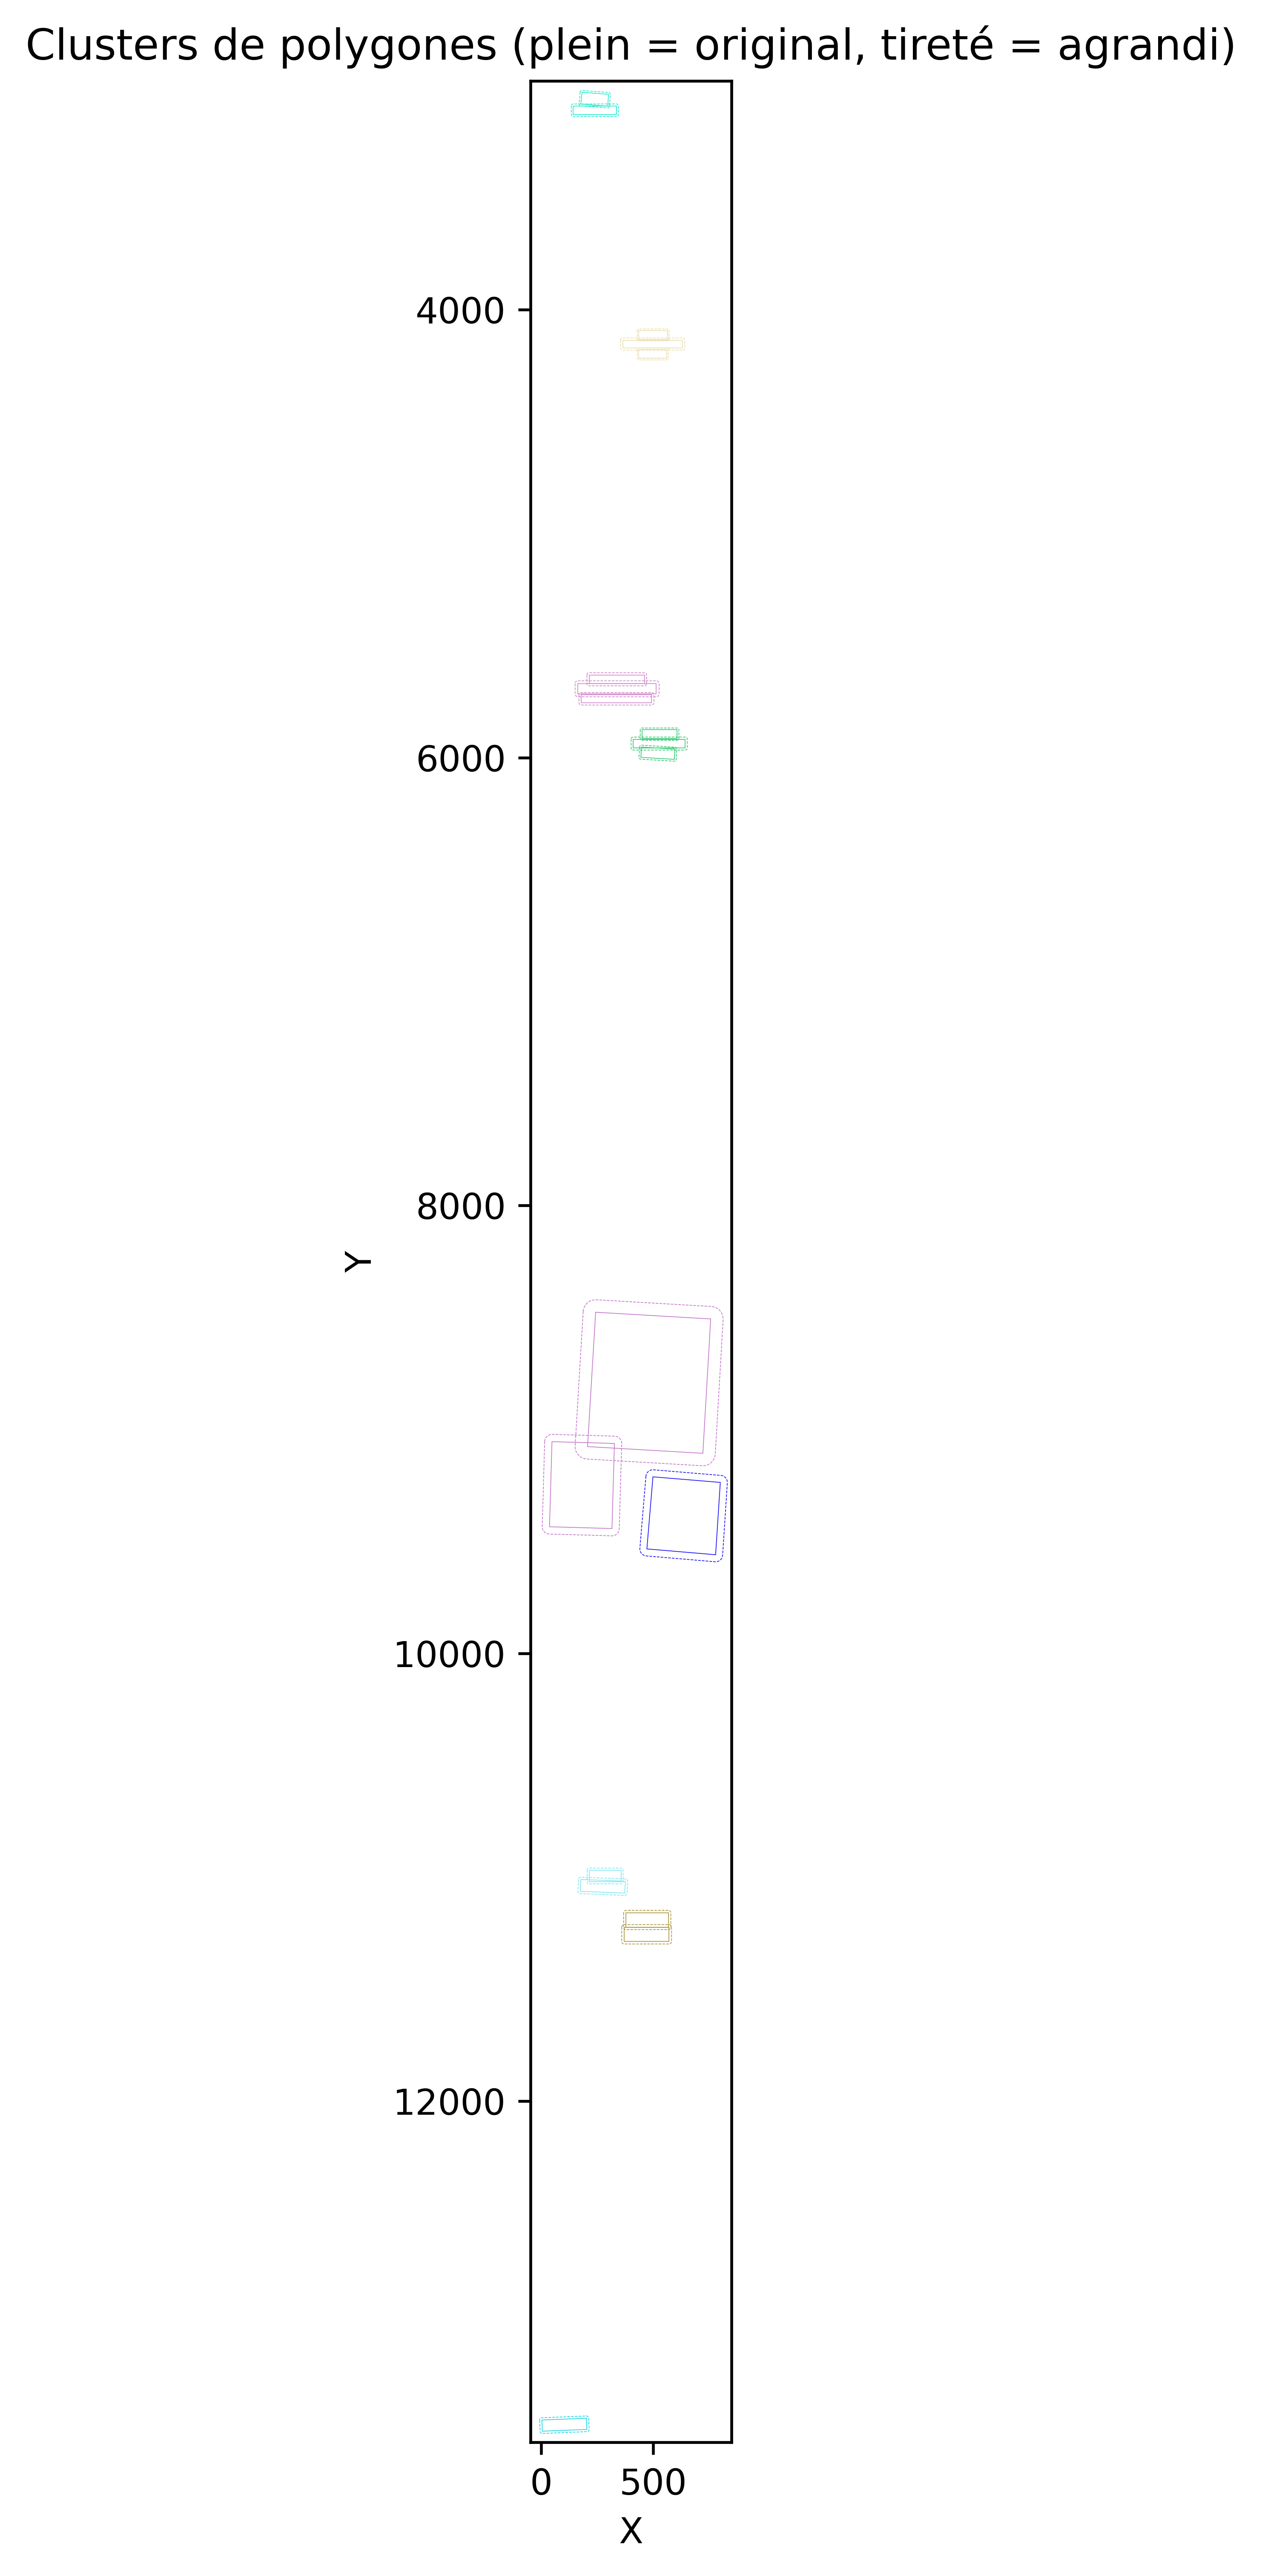

In [271]:
draw_clusters_polygons(result[0]["rec_polys"], margin_factor=0.1, dpi=600, linewidth=0.2)